In [1]:
#default_exp permutations

In [2]:
#hide
from nbdev.showdoc import *
from nbdev import *

from corradin_ovp_utils.catalog import test_data_catalog, conf_test_data_catalog
from fastcore.test import ExceptionExpected
%load_ext viztracer
%load_ext autoreload
%autoreload 2
from plotly import express as px
import matplotlib.pyplot as plt
import seaborn

In [3]:
#export
import pandas as pd
import numpy as np
from typing import Any, Dict, List, Optional, Literal, Union
from corradin_ovp_utils.odds_ratio import reconstruct_genetic_info, odds_ratio_df_single_combined, CaseControlOddsRatio, get_geno_combination_df
from fastcore.basics import basic_repr, store_attr
from copy import deepcopy
from tqdm.auto import tqdm
pd.options.mode.chained_assignment = None

# from dataclasses import dataclass
# from pydantic import BaseModel
# from itertools import product
# from ast import literal_eval

In [4]:
test_data_catalog = test_data_catalog.reload()

In [5]:
all_geno_df = test_data_catalog.load("all_geno_df")

In [6]:
odds_ratio_df_rs9610458_rs77948203 = test_data_catalog.load("odds_ratio_df_rs9610458_rs77948203")
odds_ratio_df_rs9610458_rs77948203

,rs9610458,rs77948203,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,GG,0.943,0.934,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1654,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",939,9385,9772,5076,5175
1,CC,AG,0.921,0.934,"[WTCCCT466268, WTCCCT489637, WTCCCT488814, WTC...",227,"[WTCCCT442411, WTCCCT444199, WTCCCT444742, WTC...",133,9385,9772,5076,5175
2,CC,AA,0.743,0.934,"[WTCCCT470057, WTCCCT489315, WTCCCT508408, WTC...",11,"[WTCCCT444162, WTCCCT442647, WTCCCT542697, WTC...",8,9385,9772,5076,5175
3,CT,GG,0.976,0.936,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3956,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2170,9385,9772,5076,5175
4,CT,AG,0.844,0.936,"[WTCCCT473524, WTCCCT473551, WTCCCT489609, WTC...",581,"[WTCCCT442429, WTCCCT443470, WTCCCT444145, WTC...",368,9385,9772,5076,5175
5,CT,AA,0.992,0.936,"[WTCCCT474394, WTCCCT470264, WTCCCT470548, WTC...",22,"[WTCCCT443346, WTCCCT444633, WTCCCT443601, WTC...",12,9385,9772,5076,5175
6,TT,GG,1.162,1.142,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2549,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1233,9385,9772,5076,5175
7,TT,AG,1.007,1.142,"[WTCCCT473522, WTCCCT473497, WTCCCT473514, WTC...",374,"[WTCCCT443058, WTCCCT442418, WTCCCT443471, WTC...",201,9385,9772,5076,5175
8,TT,AA,0.495,1.142,"[WTCCCT474560, WTCCCT469955, WTCCCT470219, WTC...",11,"[WTCCCT443119, WTCCCT442524, WTCCCT442733, WTC...",12,9385,9772,5076,5175


In [9]:
# import logging
# from rich.logging import RichHandler

# FORMAT = "%(message)s"
# logging.basicConfig(
#     level="NOTSET", format=FORMAT, datefmt="[%X]", handlers=[RichHandler()]
# )

# log = logging.getLogger("rich")
# log.info("Hello, World!")


[autoreload of corradin_ovp_utils.datasets.schemas failed: Traceback (most recent call last):
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
   

In [10]:
#export
class PermuteOddsRatio():
    def __init__(self,*, summary_df, single_rsid:str, all_geno_df, combo_rsid_list: List[str], permute_rsid:str, mtc_pval_thresh=None):
        store_attr()
        self.geno_each_sample_dict = reconstruct_genetic_info(self.summary_df, rsid_list = self.combo_rsid_list)
        self.permuted_geno_each_sample_dict = deepcopy(self.geno_each_sample_dict)
        self.perm_record = []
        self.reset()
        
    @property
    def permuted_odds_ratio_df(self):
        geno_each_sample_dict = self.permuted_geno_each_sample_dict
        permute_rsid = self.permute_rsid
        single_rsid = self.single_rsid
        combo_rsid_list = self.combo_rsid_list
        all_geno_df = self.all_geno_df
        
        #the randomization has to be done across cases and controls
        all_permute_genos = np.append(geno_each_sample_dict["case_geno_each_sample"][permute_rsid].values, geno_each_sample_dict["control_geno_each_sample"][permute_rsid].values)
        all_permute_genos = np.random.permutation(all_permute_genos)
        
        geno_each_sample_dict["case_geno_each_sample"][permute_rsid] = all_permute_genos[:geno_each_sample_dict["case_geno_each_sample"].shape[0]]
        geno_each_sample_dict["control_geno_each_sample"][permute_rsid] = all_permute_genos[geno_each_sample_dict["case_geno_each_sample"].shape[0]:]

        #refactor this into a function in `odds_ratio` module and use it here
        case_df = get_geno_combination_df(geno_each_sample_dict["case_geno_each_sample"], rsid_list=combo_rsid_list)
        control_df = get_geno_combination_df(geno_each_sample_dict["control_geno_each_sample"], rsid_list=combo_rsid_list)
        
        #TODO: turn all of this print into logging with Rich library (search for `print`)
        # display(all_permute_genos)
        # display(geno_each_sample_dict)
        # print("case_df")
        # display(case_df.df)
        # print("control_df")
        # display(control_df.df)
        
        #for testing
        permuted_case_control_odds_ratio_obj = CaseControlOddsRatio(case= case_df,
                    control = control_df,
                     geno_df = all_geno_df.loc[combo_rsid_list])
        odds_ratio_df_permuted = permuted_case_control_odds_ratio_obj.odds_ratios_df
        return odds_ratio_df_permuted
    
    @property
    def odds_ratio_compare_df(self):
        return self._odds_ratio_compare_df
    
    @property
    def report_df(self):
        df = self._odds_ratio_compare_df.copy(deep=True)
        df["combo_higher_than_single_binary"] = (self.summary_df["odds_ratio_combo"] > self.summary_df["odds_ratio_single"]).astype(int)
        df["combo_higher_than_single_str"] = df["combo_higher_than_single_binary"].replace({1: "higher", 0: "lower"})
        df["iter_used_for_pval"] = np.where(df["combo_higher_than_single_binary"], df["num_perm_higher"], df["num_perm_lower"])
        df["pval"] = df["iter_used_for_pval"].astype(float)/df["iterations"]
        df["pval"] = np.where(df["pval"] != 0, df["pval"].astype(float), 1/df["iterations"].astype(float))    
        
        return df
    
    def reset(self):
        self._odds_ratio_compare_df = self.summary_df[self.combo_rsid_list + ["odds_ratio_single", "odds_ratio_combo"]].copy(deep=True)
        self._odds_ratio_compare_df.loc[:,["iterations", "num_perm_lower", "num_perm_higher", "num_perm_equal"]] = 0
        self.perm_record = []
        if self.mtc_pval_thresh:
            self._odds_ratio_compare_df["mtc_pval_thresh"] = self.mtc_pval_thresh
            
    
    def perform_permutation(self,*, n_iterations, record_perm=False):
        for iteration in tqdm(range(n_iterations)):
            #print(iteration)
            odds_ratio_df_permuted = self.permuted_odds_ratio_df
            # if isinstance(odds_ratio_df_permuted, CaseControlOddsRatio):
            #     return odds_ratio_df_permuted
            self.odds_ratio_compare_df["num_perm_lower"] += (odds_ratio_df_permuted["odds_ratio"] < self.summary_df["odds_ratio_combo"]).astype(int)
            self.odds_ratio_compare_df["num_perm_higher"] += (self.summary_df["odds_ratio_combo"] < odds_ratio_df_permuted["odds_ratio"]).astype(int)
            self.odds_ratio_compare_df["num_perm_equal"] += (self.summary_df["odds_ratio_combo"] == odds_ratio_df_permuted["odds_ratio"]).astype(int)
            self.odds_ratio_compare_df["iterations"] += 1
            
            if record_perm:
                self.perm_record.append(odds_ratio_df_permuted["odds_ratio"])
                
        return self.odds_ratio_compare_df
    
    

[autoreload of corradin_ovp_utils.datasets.schemas failed: Traceback (most recent call last):
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/lab/corradin_biobank/FOR_AN/OVP/corradin_ovp_utils/.venv/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
   

In [48]:
odds_ratio_df_rs9610458_rs77948203

,rs9610458,rs77948203,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,GG,0.943,0.934,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1654,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",939,9385,9772,5076,5175
1,CC,AG,0.921,0.934,"[WTCCCT466268, WTCCCT489637, WTCCCT488814, WTC...",227,"[WTCCCT442411, WTCCCT444199, WTCCCT444742, WTC...",133,9385,9772,5076,5175
2,CC,AA,0.743,0.934,"[WTCCCT470057, WTCCCT489315, WTCCCT508408, WTC...",11,"[WTCCCT444162, WTCCCT442647, WTCCCT542697, WTC...",8,9385,9772,5076,5175
3,CT,GG,0.976,0.936,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3956,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2170,9385,9772,5076,5175
4,CT,AG,0.844,0.936,"[WTCCCT473524, WTCCCT473551, WTCCCT489609, WTC...",581,"[WTCCCT442429, WTCCCT443470, WTCCCT444145, WTC...",368,9385,9772,5076,5175
5,CT,AA,0.992,0.936,"[WTCCCT474394, WTCCCT470264, WTCCCT470548, WTC...",22,"[WTCCCT443346, WTCCCT444633, WTCCCT443601, WTC...",12,9385,9772,5076,5175
6,TT,GG,1.162,1.142,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2549,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1233,9385,9772,5076,5175
7,TT,AG,1.007,1.142,"[WTCCCT473522, WTCCCT473497, WTCCCT473514, WTC...",374,"[WTCCCT443058, WTCCCT442418, WTCCCT443471, WTC...",201,9385,9772,5076,5175
8,TT,AA,0.495,1.142,"[WTCCCT474560, WTCCCT469955, WTCCCT470219, WTC...",11,"[WTCCCT443119, WTCCCT442524, WTCCCT442733, WTC...",12,9385,9772,5076,5175


In [49]:
reconstruct_genetic_info(odds_ratio_df_rs9610458_rs77948203, rsid_list = ["rs9610458", "rs77948203"])["case_geno_each_sample"]["rs9610458"]


sample_id
WTCCCT473500    CC
WTCCCT473552    CC
WTCCCT473505    CC
WTCCCT473539    CC
WTCCCT473521    CC
                ..
WTCCCT447717    TT
WTCCCT449504    TT
WTCCCT449584    TT
WTCCCT508309    TT
WTCCCT470666    TT
Name: rs9610458, Length: 9385, dtype: object

In [50]:
reconstruct_genetic_info(odds_ratio_df_rs9610458_rs77948203, rsid_list = ["rs9610458", "rs77948203"])["control_geno_each_sample"]

,rs9610458,rs77948203
sample_id,,
WTCCCT443026,CC,GG
WTCCCT443028,CC,GG
WTCCCT442386,CC,GG
WTCCCT443786,CC,GG
WTCCCT443782,CC,GG
...,...,...
WTCCCT542520,TT,AA
WTCCCT543369,TT,AA
WTCCC88658,TT,AA


---

## Test basic functionality of `PermuteOddsRatio` object

In [33]:
test_permute_odds_ratio = PermuteOddsRatio(summary_df = odds_ratio_df_rs9610458_rs77948203,
                    single_rsid= "rs9610458",
                    combo_rsid_list= ["rs9610458", "rs77948203"],
                    all_geno_df = all_geno_df,
                    permute_rsid= "rs77948203")
test_permute_odds_ratio

In [32]:
def test_permuted_odds_ratio_df(permute_odds_ratio_obj: PermuteOddsRatio):
    geno_each_sample_dict = permute_odds_ratio_obj.permuted_geno_each_sample_dict
    permute_rsid = permute_odds_ratio_obj.permute_rsid
    single_rsid = permute_odds_ratio_obj.single_rsid
    combo_rsid_list = permute_odds_ratio_obj.combo_rsid_list
    all_geno_df = permute_odds_ratio_obj.all_geno_df
    
    #the randomization has to be done across cases and controls
    all_permute_genos = np.append(geno_each_sample_dict["case_geno_each_sample"][permute_rsid].values, geno_each_sample_dict["control_geno_each_sample"][permute_rsid].values)
    all_permute_genos = np.random.permutation(all_permute_genos)

    geno_each_sample_dict["case_geno_each_sample"][permute_rsid] = all_permute_genos[:geno_each_sample_dict["case_geno_each_sample"].shape[0]]
    geno_each_sample_dict["control_geno_each_sample"][permute_rsid] = all_permute_genos[geno_each_sample_dict["case_geno_each_sample"].shape[0]:]

    #refactor this into a function in `odds_ratio` module and use it here
    case_df = get_geno_combination_df(geno_each_sample_dict["case_geno_each_sample"], rsid_list=combo_rsid_list)
    control_df = get_geno_combination_df(geno_each_sample_dict["control_geno_each_sample"], rsid_list=combo_rsid_list)
    
    return {"all_permute_genos": all_permute_genos,
            "geno_each_sample_dict": geno_each_sample_dict,
            "case_df": case_df,
            "control_df": control_df}
            

In [40]:
result = test_permuted_odds_ratio_df(test_permute_odds_ratio)
result

{'all_permute_genos': array(['GG', 'GG', 'GG', ..., 'GG', 'GG', 'GG'], dtype=object),
 'geno_each_sample_dict': {'case_geno_each_sample':              rs9610458 rs77948203
  sample_id                        
  WTCCCT473500        CC         GG
  WTCCCT473552        CC         GG
  WTCCCT473505        CC         GG
  WTCCCT473539        CC         GG
  WTCCCT473521        CC         GG
  ...                ...        ...
  WTCCCT447717        TT         GG
  WTCCCT449504        TT         GG
  WTCCCT449584        TT         GG
  WTCCCT508309        TT         GG
  WTCCCT470666        TT         GG
  
  [9385 rows x 2 columns],
  'control_geno_each_sample':              rs9610458 rs77948203
  sample_id                        
  WTCCCT443026        CC         GG
  WTCCCT443028        CC         GG
  WTCCCT442386        CC         AG
  WTCCCT443786        CC         GG
  WTCCCT443782        CC         GG
  ...                ...        ...
  WTCCCT542520        TT         GG
  WTCCCT543369

In [41]:
result["case_df"].df

,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT468231, WTCCCT466857, WTCCCT465701, WTC...",7
1,CC,AG,"[WTCCCT489643, WTCCCT466296, WTCCCT467742, WTC...",267
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1618
3,CT,AA,"[WTCCCT489051, WTCCCT497773, WTCCCT448927, WTC...",21
4,CT,AG,"[WTCCCT473517, WTCCCT466281, WTCCCT489574, WTC...",581
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3957
6,TT,AA,"[WTCCCT467505, WTCCCT469999, WTCCCT508724, WTC...",21
7,TT,AG,"[WTCCCT473540, WTCCCT473555, WTCCCT489589, WTC...",390
8,TT,GG,"[WTCCCT473530, WTCCCT473426, WTCCCT473435, WTC...",2523


In [42]:
test_permute_odds_ratio.reset()
error_obj = test_permute_odds_ratio.perform_permutation(n_iterations=10, record_perm=True)

  0%|          | 0/10 [00:00<?, ?it/s]

0


array(['AG', 'GG', 'GG', ..., 'GG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         AG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         AG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         AG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         AG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT488871, WTCCCT500548, WTCCCT465450, WTC...",14
1,CC,AG,"[WTCCCT473500, WTCCCT473521, WTCCCT489583, WTC...",269
2,CC,GG,"[WTCCCT473552, WTCCCT473505, WTCCCT473539, WTC...",1609
3,CT,AA,"[WTCCCT515251, WTCCCT465869, WTCCCT497702, WTC...",23
4,CT,AG,"[WTCCCT473456, WTCCCT473517, WTCCCT473471, WTC...",595
5,CT,GG,"[WTCCCT473489, WTCCCT473515, WTCCCT473508, WTC...",3941
6,TT,AA,"[WTCCCT489585, WTCCCT489053, WTCCCT473290, WTC...",17
7,TT,AG,"[WTCCCT473534, WTCCCT473480, WTCCCT489602, WTC...",383
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2534


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT444803, WTCCCT442345, WTCCCT542761, WTC...",6
1,CC,AG,"[WTCCCT444804, WTCCCT444773, WTCCCT444174, WTC...",124
2,CC,GG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",950
3,CT,AA,"[WTCCCT444501, WTCCCT443270, WTCCCT542381, WTC...",8
4,CT,AG,"[WTCCCT443783, WTCCCT442409, WTCCCT443784, WTC...",318
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2224
6,TT,AA,"[WTCCCT542577, WTCCCT543254, WTCCCT543506, WTC...",8
7,TT,AG,"[WTCCCT442398, WTCCCT442405, WTCCCT444154, WTC...",195
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1243


1


array(['GG', 'GG', 'GG', ..., 'AG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         AG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         AG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         AG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT474585, WTCCCT470203, WTCCCT447711, WTC...",9
1,CC,AG,"[WTCCCT473539, WTCCCT489645, WTCCCT466267, WTC...",241
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1642
3,CT,AA,"[WTCCCT507996, WTCCCT468238, WTCCCT508710, WTC...",26
4,CT,AG,"[WTCCCT489594, WTCCCT466287, WTCCCT467708, WTC...",604
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3929
6,TT,AA,"[WTCCCT489608, WTCCCT500600, WTCCCT508864, WTC...",16
7,TT,AG,"[WTCCCT473534, WTCCCT489632, WTCCCT489593, WTC...",370
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2548


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT444174, WTCCCT442484, BLOOD291874, WTCC...",4
1,CC,AG,"[WTCCCT444738, WTCCCT444186, WTCCCT444564, WTC...",134
2,CC,GG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",942
3,CT,AA,"[WTCCCT442659, WTCCCT443005, WTCCCT542810, WTC...",12
4,CT,AG,"[WTCCCT443783, WTCCCT442392, WTCCCT443446, WTC...",351
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2187
6,TT,AA,"[WTCCCT442445, WTCCCT443724, WTCCCT543166, WTC...",9
7,TT,AG,"[WTCCCT444744, WTCCCT444548, WTCCCT443031, WTC...",184
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1253


2


array(['GG', 'GG', 'GG', ..., 'GG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         AG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         AG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT508677, WTCCCT474471, WTCCCT448207, WTC...",10
1,CC,AG,"[WTCCCT489643, WTCCCT467722, WTCCCT507945, WTC...",259
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1623
3,CT,AA,"[WTCCCT468673, WTCCCT497551, WTCCCT467617, WTC...",18
4,CT,AG,"[WTCCCT473544, WTCCCT489597, WTCCCT489635, WTC...",589
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3952
6,TT,AA,"[WTCCCT467529, WTCCCT489303, WTCCCT467013, WTC...",13
7,TT,AG,"[WTCCCT473537, WTCCCT489589, WTCCCT488818, WTC...",396
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2525


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT442427, WTCCCT543134, WTCCCT542238, WTC...",14
1,CC,AG,"[WTCCCT443782, WTCCCT444765, WTCCCT444227, WTC...",148
2,CC,GG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",918
3,CT,AA,"[WTCCCT442675, WTCCCT442957, WTCCCT442950, WTC...",12
4,CT,AG,"[WTCCCT442404, WTCCCT444779, WTCCCT444754, WTC...",315
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2223
6,TT,AA,"[WTCCCT543196, BLOOD292793, BLOOD293141, WTCCC...",9
7,TT,AG,"[WTCCCT443025, WTCCCT443064, WTCCCT442399, WTC...",177
8,TT,GG,"[WTCCCT443063, WTCCCT442403, WTCCCT442388, WTC...",1260


3


array(['GG', 'GG', 'GG', ..., 'AG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         AG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         AG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         AG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         AG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT448926, WTCCCT471032, WTCCCT506358, WTC...",7
1,CC,AG,"[WTCCCT489646, WTCCCT466267, WTCCCT489651, WTC...",252
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1633
3,CT,AA,"[WTCCCT465470, WTCCCT475306, WTCCCT508238, WTC...",26
4,CT,AG,"[WTCCCT473532, WTCCCT489597, WTCCCT489635, WTC...",583
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3950
6,TT,AA,"[WTCCCT497547, WTCCCT467120, WTCCCT505152, WTC...",21
7,TT,AG,"[WTCCCT473426, WTCCCT473537, WTCCCT473468, WTC...",399
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2514


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT443413, WTCCCT443843, WTCCCT511378, BLO...",4
1,CC,AG,"[WTCCCT443026, WTCCCT442386, WTCCCT444804, WTC...",141
2,CC,GG,"[WTCCCT443028, WTCCCT443786, WTCCCT443782, WTC...",935
3,CT,AA,"[WTCCCT442686, WTCCCT442842, WTCCCT442798, WTC...",10
4,CT,AG,"[WTCCCT443060, WTCCCT442415, WTCCCT442424, WTC...",328
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2212
6,TT,AA,"[WTCCCT443395, WTCCCT542396, WTCCC88714, BLOOD...",8
7,TT,AG,"[WTCCCT443063, WTCCCT443064, WTCCCT442403, WTC...",181
8,TT,GG,"[WTCCCT443025, WTCCCT442388, WTCCCT442397, WTC...",1257


4


array(['GG', 'GG', 'GG', ..., 'GG', 'AG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         AG
 WTCCCT443028        CC         AG
 WTCCCT442386        CC         AG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         AG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT449010, WTCCCT473714, WTCCCT469439, WTC...",9
1,CC,AG,"[WTCCCT489636, WTCCCT489583, WTCCCT467720, WTC...",256
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1627
3,CT,AA,"[WTCCCT473456, WTCCCT489045, WTCCCT515291, WTC...",24
4,CT,AG,"[WTCCCT473515, WTCCCT473546, WTCCCT473517, WTC...",597
5,CT,GG,"[WTCCCT473489, WTCCCT473508, WTCCCT473438, WTC...",3938
6,TT,AA,"[WTCCCT507958, WTCCCT497618, WTCCCT500589, WTC...",21
7,TT,AG,"[WTCCCT473486, WTCCCT489589, WTCCCT489632, WTC...",362
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2551


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT543302, BLOOD293188, BLOOD293182, BLOOD...",5
1,CC,AG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",158
2,CC,GG,"[WTCCCT443786, WTCCCT443782, WTCCCT442390, WTC...",917
3,CT,AA,"[WTCCCT444504, WTCCCT542189, WTCCCT542896, WTC...",11
4,CT,AG,"[WTCCCT442400, WTCCCT442401, WTCCCT444746, WTC...",327
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443059, WTC...",2212
6,TT,AA,"[WTCCCT444243, WTCCCT442946, BLOOD291715, WTCC...",6
7,TT,AG,"[WTCCCT443025, WTCCCT442416, WTCCCT442410, WTC...",184
8,TT,GG,"[WTCCCT443063, WTCCCT443064, WTCCCT442403, WTC...",1256


5


array(['GG', 'AG', 'GG', ..., 'GG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         AG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         AG
 WTCCCT449504        TT         AG
 WTCCCT449584        TT         AG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT467722, WTCCCT488882, WTCCCT469980, WTC...",7
1,CC,AG,"[WTCCCT473552, WTCCCT489583, WTCCCT489623, WTC...",224
2,CC,GG,"[WTCCCT473500, WTCCCT473505, WTCCCT473539, WTC...",1661
3,CT,AA,"[WTCCCT465506, WTCCCT465489, WTCCCT466166, WTC...",23
4,CT,AG,"[WTCCCT473508, WTCCCT473546, WTCCCT473529, WTC...",626
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3910
6,TT,AA,"[WTCCCT508765, WTCCCT497858, WTCCCT475709, WTC...",18
7,TT,AG,"[WTCCCT473540, WTCCCT473555, WTCCCT473537, WTC...",369
8,TT,GG,"[WTCCCT473530, WTCCCT473426, WTCCCT473435, WTC...",2547


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT442663, WTCCCT443165, WTCCC88294, WTCCC...",8
1,CC,AG,"[WTCCCT444781, WTCCCT444137, WTCCCT444800, WTC...",147
2,CC,GG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",925
3,CT,AA,"[WTCCCT442862, WTCCCT442448, WTCCCT444864, WTC...",11
4,CT,AG,"[WTCCCT443066, WTCCCT442425, WTCCCT442401, WTC...",316
5,CT,GG,"[WTCCCT443065, WTCCCT443059, WTCCCT443060, WTC...",2223
6,TT,AA,"[WTCCCT542353, WTCCCT542542, WTCCCT542467, WTC...",9
7,TT,AG,"[WTCCCT442388, WTCCCT442417, WTCCCT443780, WTC...",202
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1235


6


array(['GG', 'GG', 'GG', ..., 'GG', 'GG', 'AG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         AG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         AG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         AG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         AG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT500625, WTCCCT465441, WTCCCT468189, WTC...",12
1,CC,AG,"[WTCCCT473539, WTCCCT467720, WTCCCT467713, WTC...",252
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1628
3,CT,AA,"[WTCCCT466199, WTCCCT449028, WTCCCT474626, WTC...",20
4,CT,AG,"[WTCCCT473508, WTCCCT473512, WTCCCT489597, WTC...",592
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3947
6,TT,AA,"[WTCCCT507998, WTCCCT467582, WTCCCT466985, WTC...",17
7,TT,AG,"[WTCCCT473468, WTCCCT473454, WTCCCT489632, WTC...",390
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2527


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT442598, WTCCCT443478, WTCCCT443795, WTC...",4
1,CC,AG,"[WTCCCT444737, WTCCCT444137, WTCCCT444227, WTC...",135
2,CC,GG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",941
3,CT,AA,"[WTCCCT443421, WTCCCT542816, WTCCCT542912, WTC...",14
4,CT,AG,"[WTCCCT443059, WTCCCT443060, WTCCCT442404, WTC...",327
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443061, WTC...",2209
6,TT,AA,"[WTCCCT442850, WTCCCT542276, WTCCCT543453, WTC...",9
7,TT,AG,"[WTCCCT443064, WTCCCT442419, WTCCCT444727, WTC...",188
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT442403, WTC...",1249


7


array(['GG', 'AG', 'GG', ..., 'GG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         AG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         AG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         AG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT467704, WTCCCT474411, WTCCCT476410, WTC...",12
1,CC,AG,"[WTCCCT473552, WTCCCT473539, WTCCCT489583, WTC...",227
2,CC,GG,"[WTCCCT473500, WTCCCT473505, WTCCCT473521, WTC...",1653
3,CT,AA,"[WTCCCT474421, WTCCCT474584, WTCCCT489159, WTC...",22
4,CT,AG,"[WTCCCT473546, WTCCCT473466, WTCCCT473492, WTC...",568
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3969
6,TT,AA,"[WTCCCT467791, WTCCCT508728, WTCCCT489173, WTC...",18
7,TT,AG,"[WTCCCT473430, WTCCCT473468, WTCCCT473520, WTC...",400
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473555, WTC...",2516


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT442653, WTCCCT444813, WTCCCT444565, WTC...",5
1,CC,AG,"[WTCCCT444766, WTCCCT444186, WTCCCT444773, WTC...",148
2,CC,GG,"[WTCCCT443026, WTCCCT443028, WTCCCT442386, WTC...",927
3,CT,AA,"[WTCCCT443405, WTCCCT543278, WTCCCT442981, WTC...",14
4,CT,AG,"[WTCCCT443059, WTCCCT443060, WTCCCT442412, WTC...",332
5,CT,GG,"[WTCCCT443065, WTCCCT443066, WTCCCT443061, WTC...",2204
6,TT,AA,"[WTCCCT443103, WTCCC89347, WTCCCT511807, WTCCC...",5
7,TT,AG,"[WTCCCT443064, WTCCCT442399, WTCCCT443798, WTC...",209
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT442403, WTC...",1232


8


array(['GG', 'GG', 'GG', ..., 'AG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         GG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         AG
 ...                ...        ...
 WTCCCT447717        TT         GG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         AG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         GG
 WTCCCT443028        CC         AG
 WTCCCT442386        CC         AG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         AG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         AG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT467720, WTCCCT474615, WTCCCT475213, WTC...",13
1,CC,AG,"[WTCCCT473521, WTCCCT489578, WTCCCT466266, WTC...",233
2,CC,GG,"[WTCCCT473500, WTCCCT473552, WTCCCT473505, WTC...",1646
3,CT,AA,"[WTCCCT488846, WTCCCT489065, WTCCCT508288, WTC...",18
4,CT,AG,"[WTCCCT473459, WTCCCT473471, WTCCCT489597, WTC...",612
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3929
6,TT,AA,"[WTCCCT489608, WTCCCT465890, WTCCCT507979, WTC...",17
7,TT,AG,"[WTCCCT473555, WTCCCT489632, WTCCCT488818, WTC...",366
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473426, WTC...",2551


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT444651, WTCCCT542657, WTCCCT543159, WTC...",7
1,CC,AG,"[WTCCCT443028, WTCCCT442386, WTCCCT442426, WTC...",130
2,CC,GG,"[WTCCCT443026, WTCCCT443786, WTCCCT443782, WTC...",943
3,CT,AA,"[WTCCCT442659, WTCCCT443615, WTCCCT543260, WTC...",18
4,CT,AG,"[WTCCCT443065, WTCCCT443059, WTCCCT442400, WTC...",351
5,CT,GG,"[WTCCCT443066, WTCCCT443060, WTCCCT443061, WTC...",2181
6,TT,AA,"[WTCCCT443282, WTCCCT510128, WTCCCT543236]",3
7,TT,AG,"[WTCCCT442388, WTCCCT442417, WTCCCT442419, WTC...",192
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1251


9


array(['GG', 'AG', 'GG', ..., 'GG', 'GG', 'GG'], dtype=object)

{'case_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT473500        CC         GG
 WTCCCT473552        CC         AG
 WTCCCT473505        CC         GG
 WTCCCT473539        CC         GG
 WTCCCT473521        CC         GG
 ...                ...        ...
 WTCCCT447717        TT         AG
 WTCCCT449504        TT         GG
 WTCCCT449584        TT         GG
 WTCCCT508309        TT         GG
 WTCCCT470666        TT         GG
 
 [9385 rows x 2 columns],
 'control_geno_each_sample':              rs9610458 rs77948203
 sample_id                        
 WTCCCT443026        CC         AG
 WTCCCT443028        CC         GG
 WTCCCT442386        CC         GG
 WTCCCT443786        CC         GG
 WTCCCT443782        CC         GG
 ...                ...        ...
 WTCCCT542520        TT         GG
 WTCCCT543369        TT         GG
 WTCCC88658          TT         GG
 WTCCCT511508        TT         GG
 BLOOD293241         TT         GG
 
 [5076 

case_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCCT508716, WTCCCT468976, WTCCCT466859, WTC...",7
1,CC,AG,"[WTCCCT473552, WTCCCT466266, WTCCCT466294, WTC...",256
2,CC,GG,"[WTCCCT473500, WTCCCT473505, WTCCCT473539, WTC...",1629
3,CT,AA,"[WTCCCT467450, WTCCCT466217, WTCCCT474640, WTC...",24
4,CT,AG,"[WTCCCT473438, WTCCCT473447, WTCCCT473544, WTC...",601
5,CT,GG,"[WTCCCT473489, WTCCCT473456, WTCCCT473515, WTC...",3934
6,TT,AA,"[WTCCCT508626, WTCCCT474617, WTCCCT466003, WTC...",15
7,TT,AG,"[WTCCCT473555, WTCCCT473468, WTCCCT489608, WTC...",377
8,TT,GG,"[WTCCCT473540, WTCCCT473530, WTCCCT473426, WTC...",2542


control_df


,rs9610458,rs77948203,unique_samples_id,unique_samples_count
0,CC,AA,"[WTCCC66911, BLOOD292507, BLOOD293745, BLOOD29...",4
1,CC,AG,"[WTCCCT443026, WTCCCT444781, WTCCCT444137, WTC...",121
2,CC,GG,"[WTCCCT443028, WTCCCT442386, WTCCCT443786, WTC...",955
3,CT,AA,"[WTCCCT442499, WTCCCT542205, WTCCCT542678, WTC...",16
4,CT,AG,"[WTCCCT443066, WTCCCT442412, WTCCCT442415, WTC...",345
5,CT,GG,"[WTCCCT443065, WTCCCT443059, WTCCCT443060, WTC...",2189
6,TT,AA,"[WTCCCT442822, WTCCCT444672, WTCCCT443697, WTC...",10
7,TT,AG,"[WTCCCT443789, WTCCCT444801, WTCCCT444548, WTC...",184
8,TT,GG,"[WTCCCT443025, WTCCCT443063, WTCCCT443064, WTC...",1252


**UKB data object**

In [43]:
permutation_error_rs134490_rs5762201_UKB = test_data_catalog.reload().load("permutation_error_rs134490_rs5762201_UKB")
#recreate the object here to get the latest changes from PermuteOddsRatio in this file

test_perm_obj_rs134490_rs5762201_UKB = PermuteOddsRatio(summary_df = permutation_error_rs134490_rs5762201_UKB.summary_df,
                                                        single_rsid = permutation_error_rs134490_rs5762201_UKB.single_rsid,
                                                        all_geno_df = permutation_error_rs134490_rs5762201_UKB.all_geno_df, 
                                                        combo_rsid_list= permutation_error_rs134490_rs5762201_UKB.combo_rsid_list,
                                                        permute_rsid= permutation_error_rs134490_rs5762201_UKB.permute_rsid, 
                                                        mtc_pval_thresh= permutation_error_rs134490_rs5762201_UKB.mtc_pval_thresh)

test_perm_obj_rs134490_rs5762201_UKB

---

## Testing that the mean of permutations equals to mean GWAS odds

In [17]:
test_permute_odds_ratio.report_df

,rs9610458,rs77948203,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,num_perm_equal,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,pval
0,CC,GG,0.934,0.943,100,57,43,0,1,higher,43,0.43
1,CC,AG,0.934,0.921,100,42,58,0,0,lower,42,0.42
2,CC,AA,0.934,0.743,100,39,61,0,0,lower,39,0.39
3,CT,GG,0.936,0.976,100,95,5,0,1,higher,5,0.05
4,CT,AG,0.936,0.844,100,4,96,0,0,lower,4,0.04
5,CT,AA,0.936,0.992,100,58,42,0,1,higher,42,0.42
6,TT,GG,1.142,1.162,100,90,10,0,1,higher,10,0.10
7,TT,AG,1.142,1.007,100,13,87,0,0,lower,13,0.13
8,TT,AA,1.142,0.495,100,3,97,0,0,lower,3,0.03


In [37]:
record_df = pd.concat(test_permute_odds_ratio.perm_record, axis=1)
record_df

,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,...,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio,odds_ratio
0,0.91643,0.95474,0.93766,0.94733,0.91642,0.89971,0.95810,0.95112,0.95431,0.93216,...,0.94330,0.96010,0.94382,0.93981,0.92702,0.90283,0.93757,0.90453,0.95924,0.94267
1,1.06691,0.85297,0.96093,0.89272,1.04754,1.25074,0.85612,0.83746,0.86039,0.96737,...,0.92856,0.83465,0.93144,0.95873,0.99066,1.14468,0.93733,1.16630,0.82837,0.87293
2,1.00447,0.81117,0.45043,0.94643,1.48795,0.46325,0.74339,1.73201,0.77242,1.00447,...,0.54052,0.97353,0.58951,0.40527,1.35253,2.16494,1.00447,0.54057,0.94647,2.70704
3,0.95286,0.92922,0.90655,0.92035,0.95522,0.93374,0.94037,0.94788,0.91150,0.93640,...,0.94051,0.94436,0.97320,0.94202,0.93259,0.94443,0.96235,0.93103,0.95072,0.95245
4,0.92148,1.01387,1.13231,1.04854,0.89975,1.01443,0.97038,0.93993,1.10832,0.98523,...,0.97908,0.95955,0.86289,0.97889,1.01334,0.97755,0.88950,1.02574,0.92791,0.91873
5,1.03674,1.26280,1.08195,1.69204,1.33249,0.79484,1.08197,1.13122,0.99156,1.18053,...,0.88829,0.95681,0.74840,0.77694,0.87342,0.63553,0.91511,0.79278,1.18053,1.21757
6,1.10744,1.15645,1.14544,1.11577,1.12303,1.13384,1.13109,1.10758,1.13397,1.14142,...,1.16971,1.12688,1.16096,1.10348,1.13390,1.15723,1.13204,1.15541,1.14192,1.12250
7,1.23860,0.99685,1.05659,1.20217,1.17041,1.10871,1.09734,1.20083,1.10638,1.05441,...,0.92278,1.13278,0.97360,1.23944,1.07049,0.99218,1.11781,0.98221,1.06982,1.16548
8,1.08185,1.21736,0.86515,0.87873,0.69510,0.87873,2.16494,3.24949,0.96147,1.35272,...,1.71418,1.21736,1.15925,1.94893,1.98547,1.08187,0.87873,1.54649,0.93408,0.92710


<AxesSubplot:>

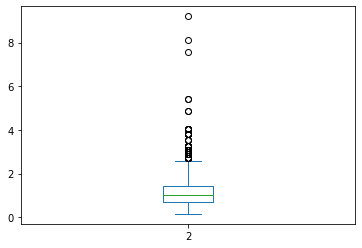

In [40]:
record_df.loc[2,:].plot.box()

In [47]:
perm_record_dict = {}
report_df_dict = {}
for step in [100, 1000, 10_000]:
    test_permute_odds_ratio.reset()
    test_permute_odds_ratio.perform_permutation(n_iterations=step, record_perm=True)
    record_df = pd.concat(test_permute_odds_ratio.perm_record, axis=1)
    report_df_dict[step] = test_permute_odds_ratio.report_df.copy()
    perm_record_dict[step] = record_df.copy()
    print(f"box plot for {step} permutations combo CT-GG")
    #display(record_df.loc[3,:].plot.box())
    print(f"mean odds ratio for {step} permutations combo CT-GG")
    display(record_df.loc[3,:].mean())
    print("median")
    display(record_df.loc[3,:].median())
    print("-------")

  0%|          | 0/100 [00:00<?, ?it/s]

box plot for 100 permutations combo CT-GG
mean odds ratio for 100 permutations combo CT-GG


0.9450707

median


0.9443900000000001

-------


  0%|          | 0/1000 [00:00<?, ?it/s]

box plot for 1000 permutations combo CT-GG
mean odds ratio for 1000 permutations combo CT-GG


0.94291679

median


0.94332

-------


  0%|          | 0/10000 [00:00<?, ?it/s]

box plot for 10000 permutations combo CT-GG
mean odds ratio for 10000 permutations combo CT-GG


0.943434842

median


0.94319

-------


<AxesSubplot:>

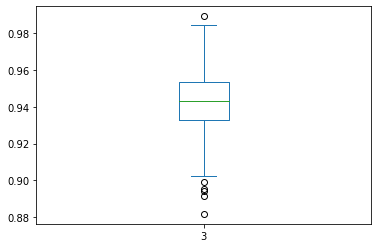

In [49]:
perm_record_dict[1000].loc[3,:].plot.box()

In [51]:
report_df_dict[1000]

,rs9610458,rs77948203,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,num_perm_equal,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,pval
0,CC,GG,0.934,0.943,1000,624,376,0,1,higher,376,0.376
1,CC,AG,0.934,0.921,1000,428,572,0,0,lower,428,0.428
2,CC,AA,0.934,0.743,1000,306,690,0,0,lower,306,0.306
3,CT,GG,0.936,0.976,1000,982,18,0,1,higher,18,0.018
4,CT,AG,0.936,0.844,1000,19,981,0,0,lower,19,0.019
5,CT,AA,0.936,0.992,1000,525,475,0,1,higher,475,0.475
6,TT,GG,1.142,1.162,1000,931,69,0,1,higher,69,0.069
7,TT,AG,1.142,1.007,1000,134,866,0,0,lower,134,0.134
8,TT,AA,1.142,0.495,1000,32,968,0,0,lower,32,0.032


---

## Testing with odds_ratio_df that contains NA

In [21]:
odds_ratio_df_rs134490_rs1004237 = test_data_catalog.load("odds_ratio_df_rs134490_rs1004237")
odds_ratio_df_rs134490_rs1004237

,rs134490,rs1004237,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,CC,1.002,1.015,"[WTCCCT489604, WTCCCT489620, WTCCCT489645, WTC...",241.0,"[WTCCCT443063, WTCCCT444200, WTCCCT444186, WTC...",130.0,8361,9772,4521,5175
1,CC,CT,NaN,1.015,None,NaN,None,NaN,8361,9772,4521,5175
2,CC,TT,NaN,1.015,None,NaN,None,NaN,8361,9772,4521,5175
3,CT,CC,0.950,0.948,"[WTCCCT473552, WTCCCT473447, WTCCCT473505, WTC...",2297.0,"[WTCCCT443025, WTCCCT443065, WTCCCT443026, WTC...",1289.0,8361,9772,4521,5175
4,CT,CT,NaN,0.948,None,NaN,None,NaN,8361,9772,4521,5175
5,CT,TT,NaN,0.948,None,NaN,None,NaN,8361,9772,4521,5175
6,TT,CC,1.051,1.050,"[WTCCCT473530, WTCCCT473555, WTCCCT473426, WTC...",5823.0,"[WTCCCT443066, WTCCCT443064, WTCCCT443028, WTC...",3101.0,8361,9772,4521,5175
7,TT,CT,NaN,1.050,None,NaN,[WTCCCT510084],1.0,8361,9772,4521,5175
8,TT,TT,NaN,1.050,None,NaN,None,NaN,8361,9772,4521,5175


In [25]:
reconstruct_genetic_info(odds_ratio_df_rs134490_rs1004237, rsid_list=["rs134490", "rs1004237"])["case_geno_each_sample"]

,rs134490,rs1004237
sample_id,,
WTCCCT489604,CC,CC
WTCCCT489620,CC,CC
WTCCCT489645,CC,CC
WTCCCT467785,CC,CC
WTCCCT489030,CC,CC
...,...,...
WTCCCT449701,TT,CC
WTCCCT449713,TT,CC
WTCCCT473041,TT,CC


In [26]:
test_permute_odds_ratio = PermuteOddsRatio(summary_df = odds_ratio_df_rs134490_rs1004237,
                    single_rsid= "rs134490",
                    combo_rsid_list= ["rs134490", "rs1004237"],
                    all_geno_df = all_geno_df,
                    permute_rsid= "rs1004237")
test_permute_odds_ratio

In [27]:
test_permute_odds_ratio.perform_permutation(n_iterations = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

0


array(['CC', 'CC', 'CC', ..., 'CC', 'CC', 'CC'], dtype=object)

{'case_geno_each_sample':              rs134490 rs1004237
 sample_id                      
 WTCCCT489604       CC        CC
 WTCCCT489620       CC        CC
 WTCCCT489645       CC        CC
 WTCCCT467785       CC        CC
 WTCCCT489030       CC        CC
 ...               ...       ...
 WTCCCT449701       TT        CC
 WTCCCT449713       TT        CC
 WTCCCT473041       TT        CC
 WTCCCT473455       TT        CC
 WTCCCT473421       TT        CC
 
 [8361 rows x 2 columns],
 'control_geno_each_sample':              rs134490 rs1004237
 sample_id                      
 WTCCCT443063       CC        CC
 WTCCCT444200       CC        CC
 WTCCCT444186       CC        CC
 WTCCCT443031       CC        CC
 WTCCCT442711       CC        CC
 ...               ...       ...
 WS574632           TT        CC
 WS574661           TT        CC
 BLOOD294452        TT        CC
 WTCCCT511021       TT        CC
 WTCCCT510948       TT        CC
 
 [4520 rows x 2 columns]}

case_df


,rs134490,rs1004237,unique_samples_id,unique_samples_count
0,CC,CC,"[WTCCCT489604, WTCCCT489620, WTCCCT489645, WTC...",241
1,CT,CC,"[WTCCCT473552, WTCCCT473447, WTCCCT473505, WTC...",2297
2,TT,CC,"[WTCCCT473530, WTCCCT473555, WTCCCT473426, WTC...",5823


control_df


,rs134490,rs1004237,unique_samples_id,unique_samples_count
0,CC,CC,"[WTCCCT443063, WTCCCT444200, WTCCCT444186, WTC...",130
1,CT,CC,"[WTCCCT443025, WTCCCT443065, WTCCCT443026, WTC...",1289
2,TT,CC,"[WTCCCT443066, WTCCCT443064, WTCCCT443028, WTC...",3101


Series([], Name: unique_samples_count, dtype: int64)
Series([], Name: unique_samples_count, dtype: int64)


UnboundLocalError: local variable 'geno_case' referenced before assignment

In [14]:
test_permute_odds_ratio.report_df

,rs134490,rs1004237,odds_ratio_single,odds_ratio_combo,iterations,num_perm_lower,num_perm_higher,num_perm_equal,combo_higher_than_single_binary,combo_higher_than_single_str,iter_used_for_pval,pval
0,CC,CC,1.015,1.002,0,0,0,0,0,lower,0,NaN
1,CC,CT,1.015,NaN,0,0,0,0,0,lower,0,NaN
2,CC,TT,1.015,NaN,0,0,0,0,0,lower,0,NaN
3,CT,CC,0.948,0.950,0,0,0,0,1,higher,0,NaN
4,CT,CT,0.948,NaN,0,0,0,0,0,lower,0,NaN
5,CT,TT,0.948,NaN,0,0,0,0,0,lower,0,NaN
6,TT,CC,1.050,1.051,0,0,0,0,1,higher,0,NaN
7,TT,CT,1.050,NaN,0,0,0,0,0,lower,0,NaN
8,TT,TT,1.050,NaN,0,0,0,0,0,lower,0,NaN


---

## Test UKB odds ratio

In [8]:
permutation_error_rs134490_rs5762201_UKB = test_data_catalog.reload().load("permutation_error_rs134490_rs5762201_UKB")

In [9]:
permutation_error_rs134490_rs5762201_UKB.summary_df

,rs134490,rs5762201,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,AA,1.95281,1.01433,['1041588' '1042820' '2995054' '4483197' '4522...,6,['1505529' '1519989' '2019724' '2053028' '3359...,9,85921,86697,251672,253792
1,CC,AG,1.09855,1.01433,['1078521' '1187600' '1223362' '1247155' '1417...,114,['1024531' '1064606' '1070868' '1077363' '1079...,304,85921,86697,251672,253792
2,CC,GG,1.00445,1.01433,['1002197' '1002513' '1010584' ... '5863210' '...,1147,['1001398' '1001703' '1004740' ... '5872359' '...,3345,85921,86697,251672,253792
3,CT,AA,0.97636,1.00263,['1186764' '1426246' '1451881' '1723507' '1755...,43,['1056898' '1065560' '1074468' '1101815' '1103...,129,85921,86697,251672,253792
4,CT,AG,1.06638,1.00263,['1006888' '1008110' '1010482' ... '5869588' '...,1762,['1001845' '1003947' '1004277' ... '5869970' '...,4846,85921,86697,251672,253792
5,CT,GG,0.99298,1.00263,['1000350' '1000505' '1000645' ... '5872735' '...,16136,['1000258' '1000377' '1000404' ... '5873023' '...,47535,85921,86697,251672,253792
6,TT,AA,1.04182,0.99632,['1023812' '1063950' '1092872' '1130075' '1135...,170,['1018820' '1025450' '1034420' '1047213' '1069...,478,85921,86697,251672,253792
7,TT,AG,1.00456,0.99632,['1000940' '1001562' '1003137' ... '5872807' '...,6285,['1000194' '1000564' '1000968' ... '5871407' '...,18332,85921,86697,251672,253792
8,TT,GG,0.99637,0.99632,['1000149' '1000151' '1000173' ... '5873158' '...,60258,['1000025' '1000038' '1000042' ... '5873057' '...,176694,85921,86697,251672,253792


In [17]:
permutation_error_rs134490_rs5762201_UKB.summary_df.loc[0, "unique_samples_id_case"]

"['1041588' '1042820' '2995054' '4483197' '4522751' '4884354']"

In [10]:
#recreate the object here to get the latest changes from PermuteOddsRatio in this file

test_perm_obj_rs134490_rs5762201_UKB = PermuteOddsRatio(summary_df = permutation_error_rs134490_rs5762201_UKB.summary_df,
                                                        single_rsid = permutation_error_rs134490_rs5762201_UKB.single_rsid,
                                                        all_geno_df = permutation_error_rs134490_rs5762201_UKB.all_geno_df, 
                                                        combo_rsid_list= permutation_error_rs134490_rs5762201_UKB.combo_rsid_list,
                                                        permute_rsid= permutation_error_rs134490_rs5762201_UKB.permute_rsid, 
                                                        mtc_pval_thresh= permutation_error_rs134490_rs5762201_UKB.mtc_pval_thresh)

test_perm_obj_rs134490_rs5762201_UKB

In [11]:
permutation_error_rs134490_rs5762201_UKB.summary_df

,rs134490,rs5762201,odds_ratio_combo,odds_ratio_single,unique_samples_id_case,unique_samples_count_case,unique_samples_id_control,unique_samples_count_control,case_total_no_NA,case_total_with_NA,control_total_no_NA,control_total_with_NA
0,CC,AA,1.95281,1.01433,['1041588' '1042820' '2995054' '4483197' '4522...,6,['1505529' '1519989' '2019724' '2053028' '3359...,9,85921,86697,251672,253792
1,CC,AG,1.09855,1.01433,['1078521' '1187600' '1223362' '1247155' '1417...,114,['1024531' '1064606' '1070868' '1077363' '1079...,304,85921,86697,251672,253792
2,CC,GG,1.00445,1.01433,['1002197' '1002513' '1010584' ... '5863210' '...,1147,['1001398' '1001703' '1004740' ... '5872359' '...,3345,85921,86697,251672,253792
3,CT,AA,0.97636,1.00263,['1186764' '1426246' '1451881' '1723507' '1755...,43,['1056898' '1065560' '1074468' '1101815' '1103...,129,85921,86697,251672,253792
4,CT,AG,1.06638,1.00263,['1006888' '1008110' '1010482' ... '5869588' '...,1762,['1001845' '1003947' '1004277' ... '5869970' '...,4846,85921,86697,251672,253792
5,CT,GG,0.99298,1.00263,['1000350' '1000505' '1000645' ... '5872735' '...,16136,['1000258' '1000377' '1000404' ... '5873023' '...,47535,85921,86697,251672,253792
6,TT,AA,1.04182,0.99632,['1023812' '1063950' '1092872' '1130075' '1135...,170,['1018820' '1025450' '1034420' '1047213' '1069...,478,85921,86697,251672,253792
7,TT,AG,1.00456,0.99632,['1000940' '1001562' '1003137' ... '5872807' '...,6285,['1000194' '1000564' '1000968' ... '5871407' '...,18332,85921,86697,251672,253792
8,TT,GG,0.99637,0.99632,['1000149' '1000151' '1000173' ... '5873158' '...,60258,['1000025' '1000038' '1000042' ... '5873057' '...,176694,85921,86697,251672,253792


In [15]:
test_perm_obj_rs134490_rs5762201_UKB.permuted_geno_each_sample_dict["case_geno_each_sample"]

,rs134490,rs5762201
sample_id,,
['1041588' '1042820' '2995054' '4483197' '4522751' '4884354'],CC,GG
['1078521' '1187600' '1223362' '1247155' '1417959' '1470100' '1479298'\n '1544880' '1566683' '1693972' '1746679' '1769678' '1798131' '1862811'\n '1871102' '1901331' '1930840' '2114115' '2141152' '2151410' '2246464'\n '2253730' '2256570' '2491348' '2557922' '2577869' '2757905' '2879982'\n '2886322' '2919415' '2964909' '3022811' '3030458' '3044233' '3097727'\n '3122804' '3130209' '3204622' '3210623' '3215316' '3221530' '3269816'\n '3285015' '3313997' '3336974' '3345594' '3373914' '3394193' '3396786'\n '3402865' '3414587' '3419118' '3474291' '3561913' '3629650' '3689008'\n '3835499' '3854915' '3864323' '3999922' '4041930' '4101483' '4212093'\n '4229690' '4245834' '4249670' '4254466' '4266769' '4268813' '4313762'\n '4321780' '4389232' '4431040' '4588727' '4614602' '4680901' '4685678'\n '4713701' '4727310' '4801375' '4814447' '4869004' '4905096' '4939650'\n '4957965' '4968189' '4985573' '5020986' '5062619' '5074859' '5097147'\n '5108993' '5138506' '5151263' '5175420' '5180837' '5191212' '5266816'\n '5288496' '5380247' '5495344' '5510656' '5522632' '5541471' '5543440'\n '5560962' '5620931' '5624779' '5645418' '5646537' '5716486' '5722181'\n '5770817' '5772436'],CC,AG
['1002197' '1002513' '1010584' ... '5863210' '5866536' '5868348'],CC,AG
['1186764' '1426246' '1451881' '1723507' '1755428' '1901090' '2315127'\n '2462759' '2478473' '2585870' '2694211' '2752952' '2788601' '2937712'\n '2939092' '3350381' '3427122' '3526095' '3597891' '3613347' '3621976'\n '3659807' '3758792' '3776353' '3894721' '3947748' '3955243' '4137331'\n '4208011' '4445560' '4472778' '4634809' '4637262' '4767447' '4835532'\n '4948180' '5420001' '5568088' '5583051' '5666690' '5700390' '5863421'\n '5867790'],CT,AA
['1006888' '1008110' '1010482' ... '5869588' '5869855' '5872908'],CT,GG
['1000350' '1000505' '1000645' ... '5872735' '5872754' '5872881'],CT,GG
['1023812' '1063950' '1092872' '1130075' '1135461' '1175991' '1199482'\n '1201142' '1216613' '1229104' '1250740' '1304451' '1310862' '1327776'\n '1327977' '1329245' '1382716' '1384040' '1402563' '1410398' '1437452'\n '1447678' '1499469' '1539061' '1568521' '1612264' '1633079' '1647959'\n '1656348' '1663314' '1690240' '1703970' '1705862' '1725315' '1786165'\n '1811109' '1823854' '1836944' '1851976' '1866003' '1878612' '1884172'\n '1906784' '1911564' '1920677' '1926072' '1930247' '1931214' '1954926'\n '1975565' '1996315' '2097815' '2118488' '2126425' '2186336' '2430480'\n '2440188' '2480670' '2490509' '2523201' '2557831' '2569715' '2589496'\n '2603314' '2609699' '2631008' '2697960' '2764859' '2799452' '2808529'\n '2886107' '2908771' '2917736' '2938141' '2960306' '2997796' '3075321'\n '3142600' '3149249' '3166252' '3195358' '3256299' '3293523' '3371056'\n '3402892' '3404873' '3411533' '3420587' '3425957' '3428906' '3438543'\n '3454456' '3461844' '3517974' '3540277' '3560925' '3566386' '3571395'\n '3607104' '3625635' '3730489' '3732427' '3766338' '3773542' '3784236'\n '3796613' '3802217' '3805076' '3834806' '3861657' '3864439' '3876864'\n '3885456' '3898483' '3905606' '3910105' '4011559' '4070070' '4082412'\n '4084619' '4117325' '4139724' '4191769' '4205687' '4276960' '4279200'\n '4332212' '4387028' '4391115' '4440985' '4455092' '4458741' '4488198'\n '4497587' '4630273' '4651211' '4653937' '4679169' '4690590' '4715606'\n '4726801' '4794302' '4881635' '4946731' '5036569' '5057348' '5080939'\n '5122889' '5155229' '5244668' '5262460' '5296072' '5301327' '5302762'\n '5345094' '5418977' '5443277' '5450829' '5496249' '5551584' '5569573'\n '5587021' '5599782' '5610049' '5621083' '5655248' '5663841' '5774152'\n '5804155' '5810368'],TT,GG
['1000940' '1001562' '1003137' ... '5872807' '5872966' '5873180'],TT,AA
['1000149' '1000151' '1000173' ... '5873158' '5873167' '5873175'],TT,AG


In [72]:
get_geno_combination_df(geno_each_sample_df=test_perm_obj_rs134490_rs5762201_UKB.permuted_geno_each_sample_dict["case_geno_each_sample"], rsid_list=test_perm_obj_rs134490_rs5762201_UKB.combo_rsid_list).df

,rs134490,rs5762201,unique_samples_id,unique_samples_count
0,CC,AA,[['1041588' '1042820' '2995054' '4483197' '452...,2
1,CC,AG,[['1002197' '1002513' '1010584' ... '5863210' ...,1
2,CT,AA,[['1186764' '1426246' '1451881' '1723507' '175...,2
3,CT,GG,[['1006888' '1008110' '1010482' ... '5869588' ...,1
4,TT,AG,[['1023812' '1063950' '1092872' '1130075' '113...,1
5,TT,GG,[['1000940' '1001562' '1003137' ... '5872807' ...,2


In [14]:
test_perm_obj_rs134490_rs5762201_UKB.permuted_odds_ratio_df

array(['GG', 'AG', 'AG', 'AA', 'GG', 'GG', 'GG', 'AA', 'AG', 'GG', 'AA',
       'AA', 'AG', 'GG', 'AG', 'AA', 'AG', 'AA'], dtype=object)

{'case_geno_each_sample':                                                    rs134490 rs5762201
 sample_id                                                            
 ['1041588' '1042820' '2995054' '4483197' '45227...       CC        GG
 ['1078521' '1187600' '1223362' '1247155' '14179...       CC        AG
 ['1002197' '1002513' '1010584' ... '5863210' '5...       CC        AG
 ['1186764' '1426246' '1451881' '1723507' '17554...       CT        AA
 ['1006888' '1008110' '1010482' ... '5869588' '5...       CT        GG
 ['1000350' '1000505' '1000645' ... '5872735' '5...       CT        GG
 ['1023812' '1063950' '1092872' '1130075' '11354...       TT        GG
 ['1000940' '1001562' '1003137' ... '5872807' '5...       TT        AA
 ['1000149' '1000151' '1000173' ... '5873158' '5...       TT        AG,
 'control_geno_each_sample':                                                    rs134490 rs5762201
 sample_id                                                            
 ['1505529' '1519989' '

case_df


,rs134490,rs5762201,unique_samples_id,unique_samples_count
0,CC,AG,[['1078521' '1187600' '1223362' '1247155' '141...,2
1,CC,GG,[['1041588' '1042820' '2995054' '4483197' '452...,1
2,CT,AA,[['1186764' '1426246' '1451881' '1723507' '175...,1
3,CT,GG,[['1006888' '1008110' '1010482' ... '5869588' ...,2
4,TT,AA,[['1000940' '1001562' '1003137' ... '5872807' ...,1
5,TT,AG,[['1000149' '1000151' '1000173' ... '5873158' ...,1
6,TT,GG,[['1023812' '1063950' '1092872' '1130075' '113...,1


control_df


,rs134490,rs5762201,unique_samples_id,unique_samples_count
0,CC,AA,[['1024531' '1064606' '1070868' '1077363' '107...,2
1,CC,GG,[['1505529' '1519989' '2019724' '2053028' '335...,1
2,CT,AG,[['1056898' '1065560' '1074468' '1101815' '110...,2
3,CT,GG,[['1001845' '1003947' '1004277' ... '5869970' ...,1
4,TT,AA,[['1018820' '1025450' '1034420' '1047213' '106...,2
5,TT,AG,[['1000194' '1000564' '1000968' ... '5871407' ...,1


Series([], Name: unique_samples_count, dtype: int64)


UnboundLocalError: local variable 'geno_case' referenced before assignment